In [9]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandas.plotting import table

file = "/workspaces/SPL/Middleput/points.xlsx"
data = pd.read_excel(file)

In [10]:

def compute_player_summaries(data):
    """
    Compute player summaries based on the provided data.
    
    Args:
    - data (pd.DataFrame): The input data containing player details and performance metrics.
    
    Returns:
    - pd.DataFrame: A summary dataframe containing computed metrics for each player.
    """
    # Define aggregation functions for the columns of interest
    aggregations = {
        'Date': 'count',
        'Penalty': 'sum',
        'Friend Referrals': 'sum',
        'Own Goals': 'sum',
        'Goals Conceded': 'sum',
        'Goals': ['mean', 'sum'],
        'Total Points': ['mean', 'sum'],
        'MVP': 'sum',
        'SPL Bonus': 'sum'
    }
    
    # Use groupby with multiple aggregation functions
    player_summary = data.groupby('Player').agg(aggregations)
    
    # Flatten hierarchical columns
    player_summary.columns = ['_'.join(col).strip() for col in player_summary.columns.values]
    
    # Rename columns for clarity
    columns_rename = {
        'Date_count': 'Games Played',
        'Penalty_sum': 'Penalties',
        'Friend Referrals_sum': 'Friend Referrals',
        'Own Goals_sum': 'Own Goals',
        'Goals Conceded_sum': 'Goals Conceded',
        'Goals_mean': 'Goals/Game',
        'Goals_sum': 'Total Goals',
        'Total Points_mean': 'Points/Game',
        'Total Points_sum': 'Total',
        'MVP_sum': 'MVP',
        'SPL Bonus_sum': 'SPL Bonus'
    }
    player_summary.rename(columns=columns_rename, inplace=True)
    
    # Calculate games won
    games_won = data[data['Team'] == data['Winning Team']].groupby('Player').size()
    player_summary['Games Won'] = games_won
    player_summary['Games Won'].fillna(0, inplace=True)
    
    # Calculate win ratio
    player_summary['Win Ratio'] = player_summary['Games Won'] / player_summary['Games Played']
    
    return player_summary

def calculate_cumulative_points_and_rank(data):
    """
    Calculate cumulative points and rank changes for each player.
    
    Args:
    - data (pd.DataFrame): The input data containing player details and performance metrics.
    
    Returns:
    - pd.DataFrame: A dataframe containing the 'Rank Change' for the latest game for each player.
    """
    # Calculate cumulative Total Points for each player after each game
    data['Cumulative Points'] = data.groupby('Player')['Total Points'].cumsum()
    
    # Determine the player's rank based on these cumulative points after each game
    data['Rank'] = data.groupby('Date')['Cumulative Points'].rank(method="first", ascending=False)
    
    # Sort data to ensure we process in chronological order for each player
    data_sorted = data.sort_values(by=['Player', 'Date'])
    
    # Calculate the change in rank between each game for every player
    data_sorted['Rank Change'] = data_sorted.groupby('Player')['Rank'].diff().fillna(0)
    
    # Extract the latest rank change for each player
    latest_rank_change = data_sorted.groupby('Player').apply(lambda x: x.iloc[-1])['Rank Change']
    
    return latest_rank_change

# Integrate functions to generate the final summary
player_summary = compute_player_summaries(data)
latest_rank_change = calculate_cumulative_points_and_rank(data)

# Add 'Rank Change' to the summary
player_summary['Rank Change'] = latest_rank_change

# Fill NaN values with 0
player_summary = player_summary.fillna(0)

# Convert specific columns to integer type
cols_to_int = ['Games Won', 'MVP', 'SPL Bonus', 'Rank Change']
player_summary[cols_to_int] = player_summary[cols_to_int].astype(int)

# Calculate the overall rank based on the 'Total Points'
player_summary['Rank'] = player_summary['Total'].rank(method="min", ascending=False).astype(int)

# Reorder columns to have 'Rank' at the front
column_order = ['Rank'] + [col for col in player_summary if col != 'Rank']
final_summary = player_summary[column_order]

# Sorting the final_summary DataFrame by 'Rank' in ascending order
sorted_summary = final_summary.sort_values(by='Rank')

# Setting option to display all rows
pd.set_option('display.max_rows', None)

# Reordering the columns as specified
desired_column_order = [
    "Rank", "Games Played", "Games Won", "Win Ratio", "Penalties", 
    "Friend Referrals", "Own Goals", "Goals Conceded", "MVP", "SPL Bonus",
    "Goals/Game", "Total Goals", "Points/Game", 
    "Total", "Rank Change"
]

for col in sorted_summary.columns:
    if sorted_summary[col].dtype == 'float64':
        sorted_summary[col] = sorted_summary[col].round(2)
sorted_summary['Win Ratio'] = (sorted_summary['Win Ratio'] * 100).round(0).astype(int).astype(str) + '%'
sorted_summary = sorted_summary[desired_column_order].dropna()
sorted_summary = sorted_summary.reset_index()
sorted_summary


Player  Rank  Games Played  Games Won Win Ratio  Penalties  \
0    Daniele (Francesco)     1            17         12       71%          0   
1            Luca Stoppi     2            23          8       35%          1   
2         Andrea Limonta     3            22         11       50%          0   
3        Cameron McAinsh     4            22          9       41%          0   
4      Damiano Barbanera     5            21          7       33%          0   
5        Giovanni Aiello     6            21         11       52%          0   
6                 Sergio     7            17          9       53%          0   
7      Federico Paolucci     8            19          9       47%          0   
8                  Mazzu     9            14          4       29%          0   
9             Roby (Cri)    10            16          5       31%          0   
10      Fabrizio Limonta    11            16          5       31%          0   
11     Andrea Silverstri    12            14          7       50%          0   
12    Federico (Damiano)    13            11          6       55%          0   
13                  Tito    14             9          5       56%          0   
14        Riccardo Ricci    15            10          5       50%          0   
15     Matteo (Riccardo)    15             7          5       71%          0   
16             Francesco    17            10          3       30%          0   
17                Franco    17            12          6       50%          3   
18              Maurizio    19             9          5       56%          0   
19        Cri Diaz Lopez    20             9          2       22%          0   
20                Jacopo    21            10          4       40%          0   
21         Robi (Stoppi)    22             6          5       83%          0   
22          Coyote (Cri)    23            10          2       20%          0   
23        Emilano (Dani)    24             7          2       29%          0   
24        Stefano (Tito)    25             6          4       67%          0   
25                 Pedro    26             4          3       75%          0   
26        Guido (Sergio)    27             5          2       40%          0   
27                 Cerro    28             4          4      100%          0   
28          Wissam Rahal    29             3          2       67%          0   
29        Ludovico Righi    30             4          1       25%          0   
30              Luca SDV    31             5          2       40%          0   
31              Gianluca    32             3          1       33%          0   
32           Matteo Virg    32             3          3      100%          0   
33            Davide Ang    34             3          2       67%          0   
34                  Omar    35             4          1       25%          0   
35  Alessandro Gibertini    36             3          1       33%          0   
36         Cocò (Stoppi)    36             2          2      100%          0   
37             Ale Guati    38             2          1       50%          0   
38      Andrea Scalambra    38             3          1       33%          0   
39                Thomas    40             3          1       33%          0   
40            Fede Lelli    41             2          2      100%          0   
41            Leo (Cava)    42             2          2      100%          0   
42          Marco Taglio    42             3          0        0%          0   
43           Andrea DeGa    44             3          0        0%          0   
44             Gianpiero    45             2          1       50%          0   
45           Ale (Mazzu)    46             2          1       50%          0   
46     Eugenio Gibertini    47             1          1      100%          0   
47      Giacomo (Stoppi)    48             1          1      100%          0   
48        Matteo (Mazzu)    48             1          1      100%          0   
49             Ami

In [11]:
# Save the games_df DataFrame as an Excel file
sorted_summary_excel = "/workspaces/SPL/Middleput/sorted_summary.xlsx"
sorted_summary.to_excel(sorted_summary_excel, index=False)

In [12]:
def df_to_html_updated(df):
    # Style the specific columns to be bold
    def bold_columns(series):
        col_name = series.name
        return series.map(lambda val: "font-weight: bold" if col_name in ["Player", "Rank", "Total"] else "")

    styled_df = df.style.apply(bold_columns, axis=0, subset=["Player", "Rank", "Total"])

    # Convert styled dataframe to HTML table without the default index and header tags
    table_content = styled_df.to_html(index=False, header=True)
    
    # Basic HTML structure with a placeholder for the table content
    html = f"""
       <html>
        <head>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    margin: 0;
                    padding: 0;
                }}
                table {{
                    width: 100%;
                    border-collapse: collapse;
                    margin: 25px 0;
                    font-size: 15px;
                    text-align: left;
                }}
                th, td {{
                    padding: 10px;
                    border-bottom: 1px solid #ddd;
                }}
                th {{
                    white-space: normal;
                }}
                tr:nth-child(1) {{
                    background-color: gold;
                }}
                tr:nth-child(2) {{
                    background-color: silver;
                }}
                tr:nth-child(3) {{
                    background-color: #cd7f32; /* Bronze color */
                }}
                tr:nth-child(even):not(:nth-child(-n+3)) {{
                    background-color: #f2f2f2;
                }}
                tr:nth-child(odd):not(:nth-child(-n+3)) {{
                    background-color: #ffffff;
                }}
                tr:hover {{
                    background-color: #f5f5f5;
                }}
                th {{
                    background-color: #333;
                    color: white;
                    text-align: center;
                }}
                td {{
                    text-align: center;
                }}
                td:first-child {{
                    text-align: left;
                }}
                @media (max-width: 768px) {{
                    th, td {{
                        font-size: 13px;
                    }}
                }}
            </style>
        </head>
        <body>
            {table_content}
        </body>
    </html>
    """
    
    return html

# Generate the HTML
html_content = df_to_html_updated(sorted_summary)

# Save the HTML content to a file
html_file_path = "/workspaces/SPL/Middleput/players_stats.html"
with open(html_file_path, "w") as f:
    f.write(html_content)

html_file_path


'/workspaces/SPL/Middleput/players_stats.html'

In [13]:
import pandas as pd
from bs4 import BeautifulSoup

# Read the HTML content from the file
with open("/workspaces/SPL/Middleput/players_stats.html", 'r') as file:
    html_content = file.read()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Extract the table from the parsed HTML
table = soup.find('table')

# Convert the HTML table to a pandas DataFrame
df = pd.read_html(str(table))[0]

# Round all numeric values to 2 decimal points
df = df.round(2)

# Remove the column before "Player"
df = df.drop(columns=["Unnamed: 0"])

# Convert the DataFrame back to an HTML table
html_table = df.to_html(index=False, classes="players-stats")

# Extract the styling from the original HTML
styles = soup.find('style').string

# Create a new HTML structure combining the styles and the new table
new_html_content = f"""
<html>
<head>
    <style>
        {styles}
    </style>
</head>
<body>
    {html_table}
</body>
</html>
"""

# Save the modified HTML content to a new file
with open("/workspaces/SPL/Output/players_stats_new.html", 'w') as file:
    file.write(new_html_content)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1600x1600 with 0 Axes>

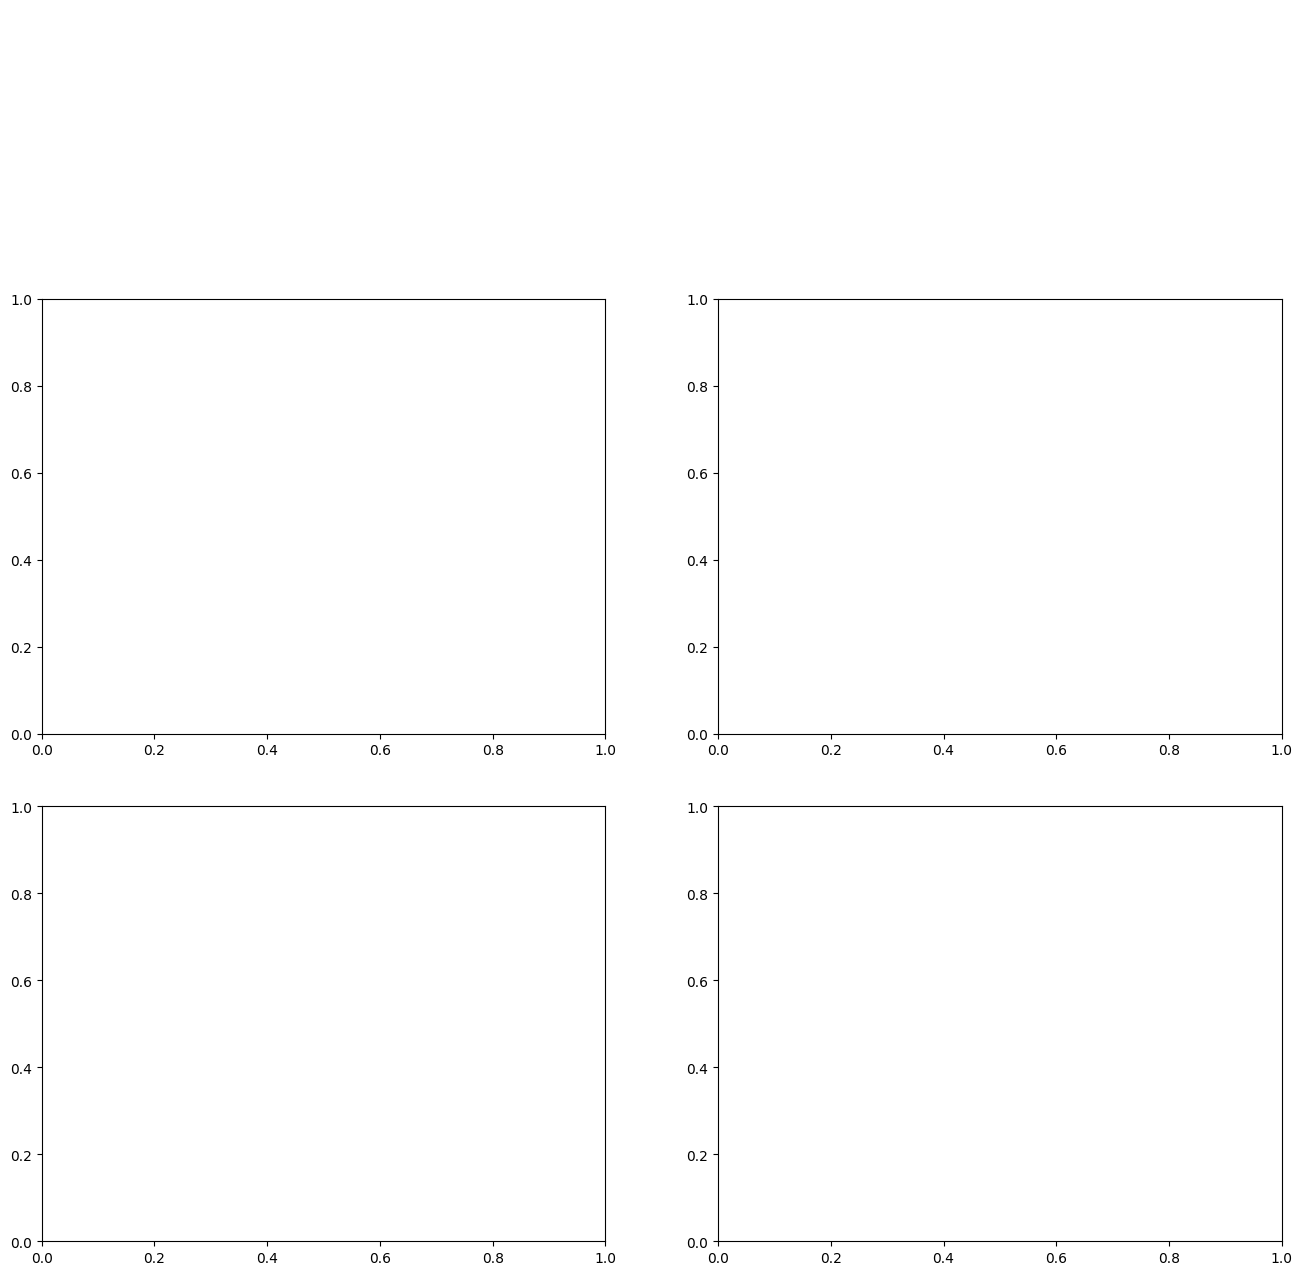

In [14]:
def player_graphs_with_summary_updated(player_name: str):
    """
    Display player summary in a table and generate four graphs for the specified player:
    - Total Points per Gameweek
    - Number of Goals per Gameweek
    - Pie chart showing Wins, Losses, and Draws
    - Line chart showing Defensive score and Midfield score over Gameweek

    Parameters:
    - player_name (str): Name of the player
    """
    
    # Filter the original data for the specified player
    player_data = data[data['Player'] == player_name]
    
    # Filter the sorted_summary data for the specified player
    player_summary = sorted_summary[sorted_summary['Player'] == player_name]
    
    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return
    
    # Set up the plot environment
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), gridspec_kw={"height_ratios": [0.2, 0.4, 0.4]})
    
    # Display the player's summary data in a table format
    # Remove the index from the table and use the player's name as the title
    axes[0, 0].axis("off")
    axes[0, 1].axis("off")
    ax_center = fig.add_subplot(3, 2, (1, 2))
    ax_center.axis("off")
    
    # Removing the index and setting the player name as title
    player_summary = player_summary.drop(columns=['Player']).T
    player_summary.columns = [player_name]
    
    tbl = table(ax_center, player_summary, loc="center", cellLoc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.0, 1.2)
    
    # Total Points per Gameweek
    sns.lineplot(x='Gameweek', y='Total Points', data=player_data, ax=axes[1, 0], marker="o")
    axes[1, 0].set_title('Total Points per Gameweek')
    axes[1, 0].set_xlabel('Gameweek')
    axes[1, 0].set_ylabel('Total Points')
    
    # Number of Goals per Gameweek
    sns.barplot(x='Gameweek', y='Goal Points', data=player_data, ax=axes[1, 1], palette="viridis")
    axes[1, 1].set_title('Number of Goals per Gameweek')
    axes[1, 1].set_xlabel('Gameweek')
    axes[1, 1].set_ylabel('Goal Points')
    
    # Pie chart showing Wins, Losses, and Draws
    game_outcomes = player_data['Game Outcome'].value_counts()
    axes[2, 0].pie(game_outcomes, labels=game_outcomes.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    axes[2, 0].set_title('Game Outcomes: Wins, Losses, Draws')
    
    # Line chart showing Defensive score and Midfield score over Gameweek
    sns.lineplot(x='Gameweek', y='Defensive Score Points', data=player_data, ax=axes[2, 1], label='Defensive Score', marker="o")
    sns.lineplot(x='Gameweek', y='Midfield Score', data=player_data, ax=axes[2, 1], label='Midfield Score', marker="o")
    axes[2, 1].set_title('Defensive and Midfield Score over Gameweek')
    axes[2, 1].set_xlabel('Gameweek')
    axes[2, 1].set_ylabel('Score')
    axes[2, 1].legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


def save_player_graphs_to_html():
    """
    Loop through all distinct players in the dataset.
    For each player, generate the plots and save them to an HTML file named after the player.
    """
    
    # Create a directory to store the images and HTML files
    if not os.path.exists("/workspaces/SPL/Middleput/player_data/player_graphs"):
        os.makedirs("/workspaces/SPL/Middleput/player_data/player_graphs")

    # Get the list of distinct players
    players = data['Player'].unique()

    # Loop through each player
    for player in players:
        # Generate the player's plots
        fig = plt.figure(figsize=(16, 16))
        player_graphs_with_summary_updated(player)
        
        # Save the plots to an image
        img_path = f"/workspaces/SPL/Middleput/player_data/player_graphs/{player}.png"
        fig.savefig(img_path)
        plt.close(fig)

        # Embed the image in an HTML file
        with open(f"/workspaces/SPL/Middleput/player_data/player_graphs/{player}.html", "w") as file:
            file.write(f"<html><body><img src='{player}.png' /></body></html>")
            
    return f"Graphs saved for {len(players)} players in /workspaces/SPL/Middleput/player_data/player_graphs"

save_player_graphs_to_html()